# Ensembled Model II - Evaluation

In this notebook, we will analyze the results given by our ensembled model focusing on the NLP models that compose it. 
First, we are going to see the metrics on which we are going to analyze our model 
Second, we proceed with the evaluation of the model. Finally, we are going to mention further analysis to perform and possible improvements

In [21]:
import os
os.chdir('/home/app/src')
import time
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import top_k_accuracy_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin


from xgboost import XGBClassifier

from utils import evaluation
from utils.build_df import build_df
from utils import tree_utils
from utils.text_normalizer import normalize_corpus
from utils.decoder import decode_id_path

from utils.combined_model_class import Combined_Model
from utils import utils_img
from utils import efficientnet

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Metrics

Accuracy is defined as the ratio of correct predictions and the total number of predictions. It is a metric that gives us a clear intuition about good predictions of our models. However, this metric is not so useful for the problem at hand which consists in a multiclass classification problem.

A better choice, in this case, is the use of top-k accuracy method which is the number of times when the correct label is among the top k labels predicted (ranked by predicted scores).

We are not so interested in giving to the user only one category for his/her product but by give several options to choose from, and hopefully, with the correct category among them.

On the other hand, we need to consider the following case: suppose that our model predicts the category "LED Monitors" but the true label, in this case, turns out to be "Monitors". In this case, the model does not predict the exact category but it makes a good prediction, by predicting a subcategory of "Monitors". 

In this way the distance between nodes, calculated with the dist_tree() function, is very useful in order to evaluate the performance of the ensembled model.


We already, incorporate the top-k accuracy in the first evaluation of our model (see `/home/app/src/model_training/ensembled_model/ensembled_model_I.ipynb`) when we choose the baseline model and the type of ensemble. Here we are going to evaluate in more detail our model now, taking into account the distance between predicted and true categories.


### Distance between nodes

In the `home/app/src/EDA/category_trees.ipynb` we focused on exploring and capturing the hierarchical structure of our labels.

According to that, we can establish the following scale attending to the distance between true and predicted labels:

**Scale of predictions**

- **dist >= 4**: bad prediction

- **dist = 3**: neutral prediction (the model sometimes predicts a category with a shared root category and sometimes doesn't)

- **dist <= 2**: good predictions (the model predicts a category with a shared root category or predicts the right category)

In what follows, we are going to use this scale to evaluate our ensemble model. And attending to the high top 5 accuracy of our model we are going to focus on those cases in which our model gives bad predictions.

## 2. Evaluation 

In [22]:
# loading results of ensemble model's performance on test set
df_model_ens = pd.read_csv('model/experiments/ENSEM_TEST_RESULTS/labels.csv')
df_model_ens.head(10)

,pred_cat,true_cat,pred_cat_dec,true_cat_dec,dist
0,pcmcat151600050037,pcmcat151600050037,Keyboards,Keyboards,0
1,pcmcat367400050002,abcat0912008,"Coffee, Tea & Espresso",Coffee Pods,2
2,abcat0507000,abcat0507000,Computer Cards & Components,Computer Cards & Components,0
3,pcmcat183800050006,pcmcat183800050006,Laptop Batteries,Laptop Batteries,0
4,pcmcat152100050038,pcmcat152100050020,Microphones,Recording Equipment,3
5,pcmcat251600050003,abcat0207000,Microphones & Accessories,Musical Instruments,2
6,pcmcat209400050001,pcmcat209400050001,All Cell Phones with Plans,All Cell Phones with Plans,0
7,abcat0912025,abcat0912025,Kitchen Gadgets,Kitchen Gadgets,0
8,pcmcat309900050001,pcmcat309900050001,iPad & Tablet Accessories,iPad & Tablet Accessories,0
9,pcmcat367400050001,pcmcat367400050001,All Refrigerators,All Refrigerators,0


In [23]:
y_true_all_ens = df_model_ens['true_cat_dec']
y_pred_all_ens = df_model_ens['pred_cat_dec']

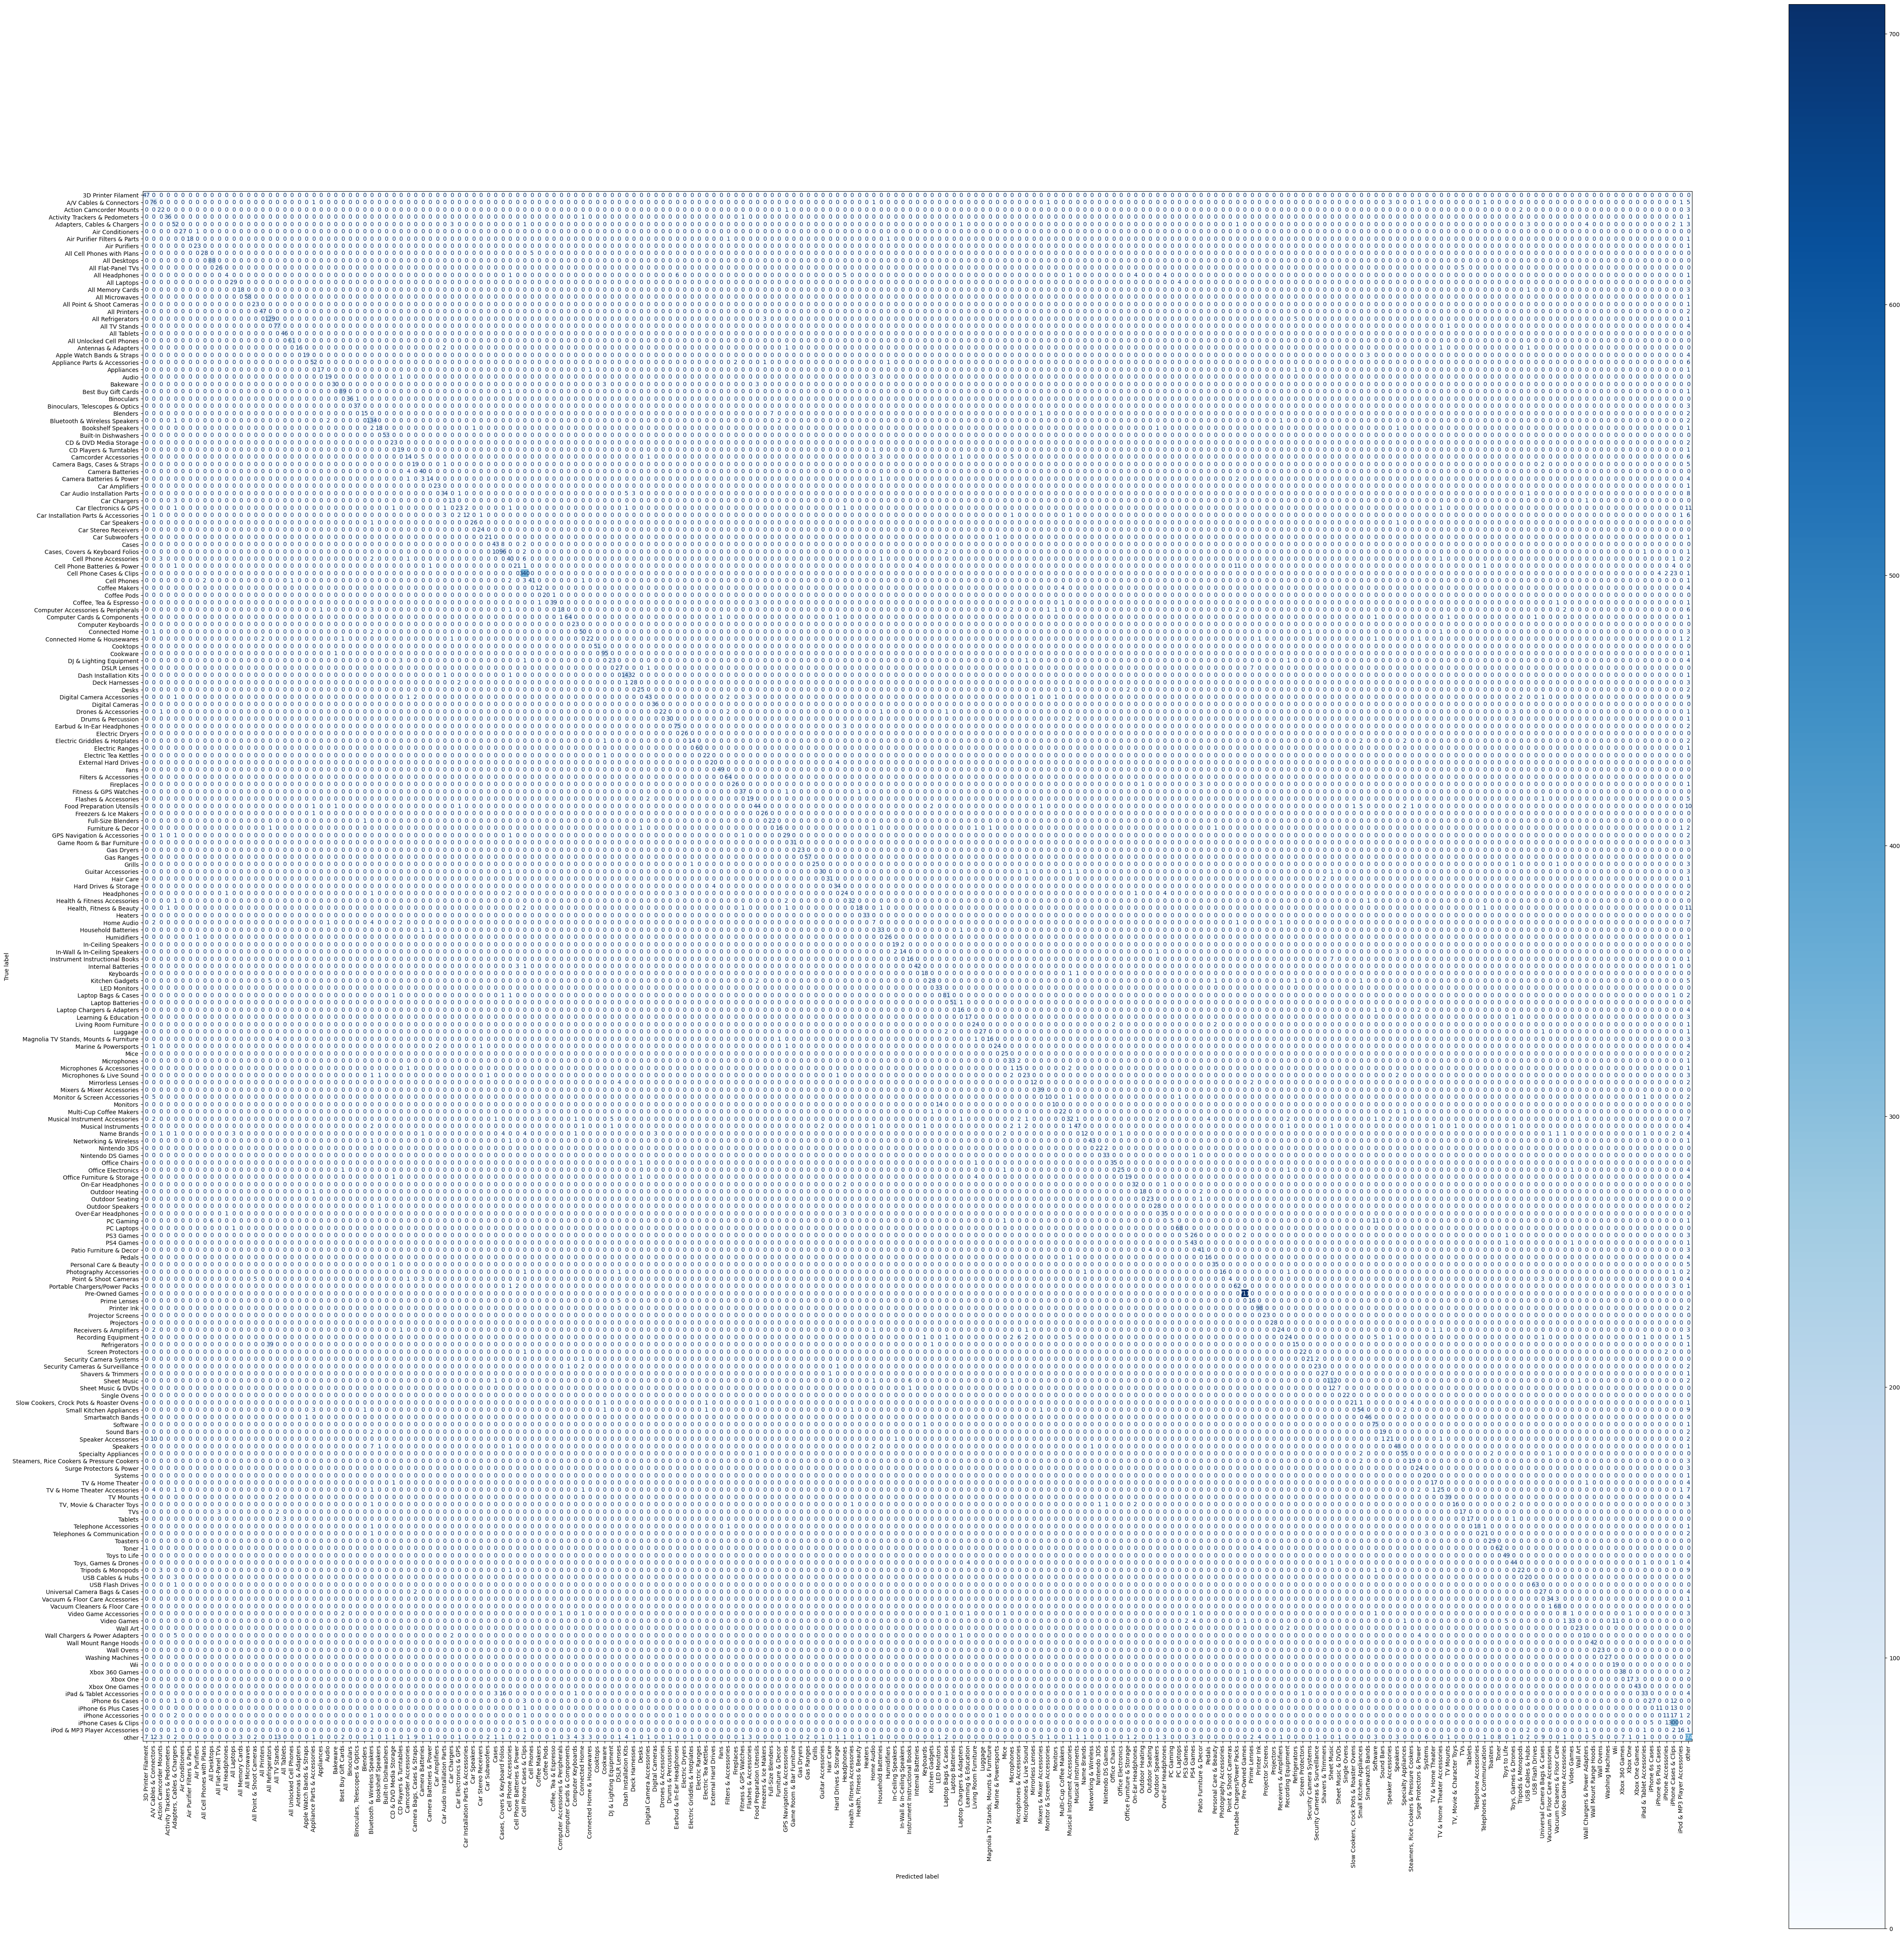

In [24]:
f,ax = plt.subplots(1,1,figsize=(60,60))
ConfusionMatrixDisplay.from_predictions(y_true=y_true_all_ens, 
                                        y_pred=y_pred_all_ens, 
                                        xticks_rotation='vertical', 
                                        cmap= 'Blues',
                                        ax=ax)
plt.show()

In [25]:
df_values_ens = pd.DataFrame(list(zip(
                                      df_model_ens['dist'].value_counts(normalize=True).index.to_list(),
                                      df_model_ens['dist'].value_counts(normalize=True).values.tolist()
                                    )),
                            columns=['Distance', 'Count'])
df_values_ens

,Distance,Count
0,0,0.833688
1,1,0.055082
2,2,0.048500
3,3,0.036012
4,4,0.023427
5,5,0.003291


In [26]:
len(df_model_ens[df_model_ens['dist'] >= 4])

276

In [27]:
bad_count = len(df_model_ens[df_model_ens['dist'] >= 4])
neutral_count = len(df_model_ens[df_model_ens['dist'] == 3])
good_count = len(df_model_ens[df_model_ens['dist'] <= 2])

bad_pred_ens = round(df_values_ens['Count'].iloc[5]*100, 2)  + round(df_values_ens['Count'].iloc[4]*100, 2) 
neutral_pred_ens = round(df_values_ens['Count'].iloc[3]*100, 2)
good_pred_ens = round(df_values_ens['Count'].iloc[2]*100, 2)  + round(df_values_ens['Count'].iloc[1]*100, 2) + round(df_values_ens['Count'].iloc[0]*100, 2) 

type_of_pred = ["Good predictions", "Neutral Predictions", "Bad Predictions"]


Good predictions: 9682
Neutral predictions: 372
Bad Predictions: 276



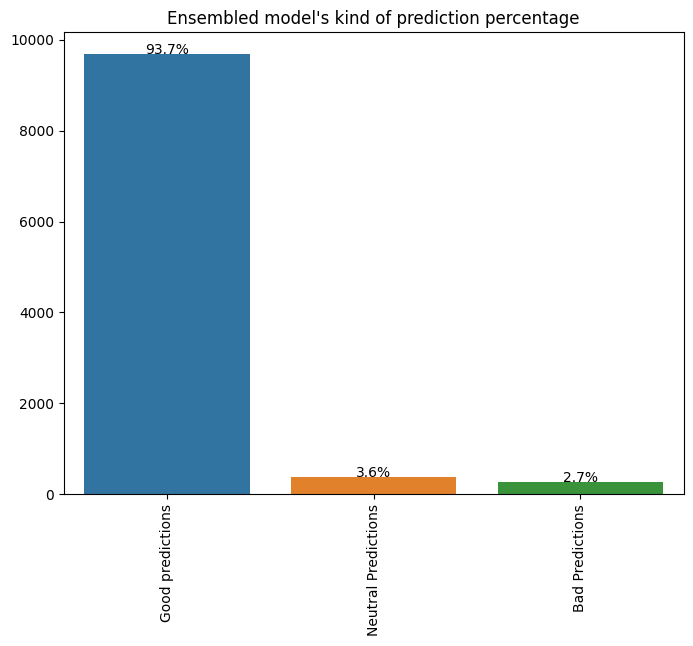

In [28]:
print(f"""
Good predictions: {good_count}
Neutral predictions: {neutral_count}
Bad Predictions: {bad_count}
""")


f = plt.figure(figsize=(8, 6))
x = type_of_pred
y = [good_count, neutral_count, bad_count]
percentage = [good_pred_ens, neutral_pred_ens, bad_pred_ens]

ax = sns.barplot(x=x, y=y)
patches = ax.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()+.05
   ax.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')
plt.xticks(rotation=90)

plt.title("""Ensembled model's kind of prediction percentage""")
plt.show()

In [29]:
df_bad_pred_ens = df_model_ens[df_model_ens['dist'] == 1].copy()

In [30]:
df_bad_pred_ens

,pred_cat,true_cat,pred_cat_dec,true_cat_dec,dist
29,abcat0706000,abcat0700000,Wii,Video Games,1
41,pcmcat200900050014,abcat0509000,LED Monitors,Monitors,1
107,other,pcmcat128500050004,other,Name Brands,1
111,other,abcat0300000,other,Car Electronics & GPS,1
123,pcmcat748300322875,pcmcat179200050008,Outdoor Seating,Patio Furniture & Decor,1
...,...,...,...,...,...
10236,abcat0908001,abcat0907001,Air Purifiers,Air Conditioners,1
10243,abcat0811004,pcmcat326000050011,Cell Phone Batteries & Power,Internal Batteries,1
10253,abcat0800000,pcmcat209400050001,Cell Phones,All Cell Phones with Plans,1
10262,pcmcat191200050015,pcmcat171900050031,iPhone Accessories,Screen Protectors,1


**Bad Predictions**

In [31]:
df_bad_pred_ens = df_model_ens[df_model_ens['dist'] >= 4].copy()

# List of categories bad predict for our model
probl_cat = df_bad_pred_ens['true_cat_dec'].value_counts().index.to_list()
df_bad_pred_ens

,pred_cat,true_cat,pred_cat_dec,true_cat_dec,dist
40,other,pcmcat151600050027,other,Pedals,4
63,other,pcmcat240500050052,other,Flashes & Accessories,4
119,abcat0515013,abcat0811007,USB Cables & Hubs,"Adapters, Cables & Chargers",4
132,other,pcmcat248300050003,other,Luggage,4
151,pcmcat326000050010,pcmcat241600050001,Portable Chargers/Power Packs,Home Audio,4
...,...,...,...,...,...
10137,other,pcmcat240500050052,other,Flashes & Accessories,4
10182,abcat0807009,other,Toner,other,4
10213,pcmcat152100050038,abcat0515000,Microphones,Computer Accessories & Peripherals,4
10270,abcat0807001,other,Printer Ink,other,4


In [32]:
print(f"""Our model failed to get good predictions for {len(df_bad_pred_ens)} products
And the number of categories involved in bad predictions is {len(probl_cat)}
""")

Our model failed to get good predictions for 276 products
And the number of categories involved in bad predictions is 69



In [33]:
df_bad_pred_ens['true_cat_dec'].value_counts(normalize=True)*100

other                            33.333333
Food Preparation Utensils         3.985507
Name Brands                       2.536232
Apple Watch Bands & Straps        2.536232
Camcorder Accessories             2.173913
                                   ...    
TV & Home Theater                 0.362319
Portable Chargers/Power Packs     0.362319
GPS Navigation & Accessories      0.362319
Car Subwoofers                    0.362319
All Memory Cards                  0.362319
Name: true_cat_dec, Length: 69, dtype: float64

From the table above, we can see that amount 33% of misclassified products correspond to products belonging to the category "other". 

As the category "other" was generated to exclude those categories with a number of products less than 100 we are going to analyze it separately


#### **Products pertaining to the category "other" and misclassified by our model**

In [34]:
df_bad_pred_other = df_bad_pred_ens[df_bad_pred_ens['true_cat_dec'] == 'other']

In [35]:
# To analyze against name and description
idx_others = df_bad_pred_other.index.to_list()

In [36]:
pred_cat_no_other = df_bad_pred_other['pred_cat_dec'].value_counts().index.tolist()
count_pred_cat_no_other = df_bad_pred_other['pred_cat_dec'].value_counts().values.tolist()
perc_pred_cat_no_other = [round((x/len(df_bad_pred_ens))*100, 2) for x in count_pred_cat_no_other]

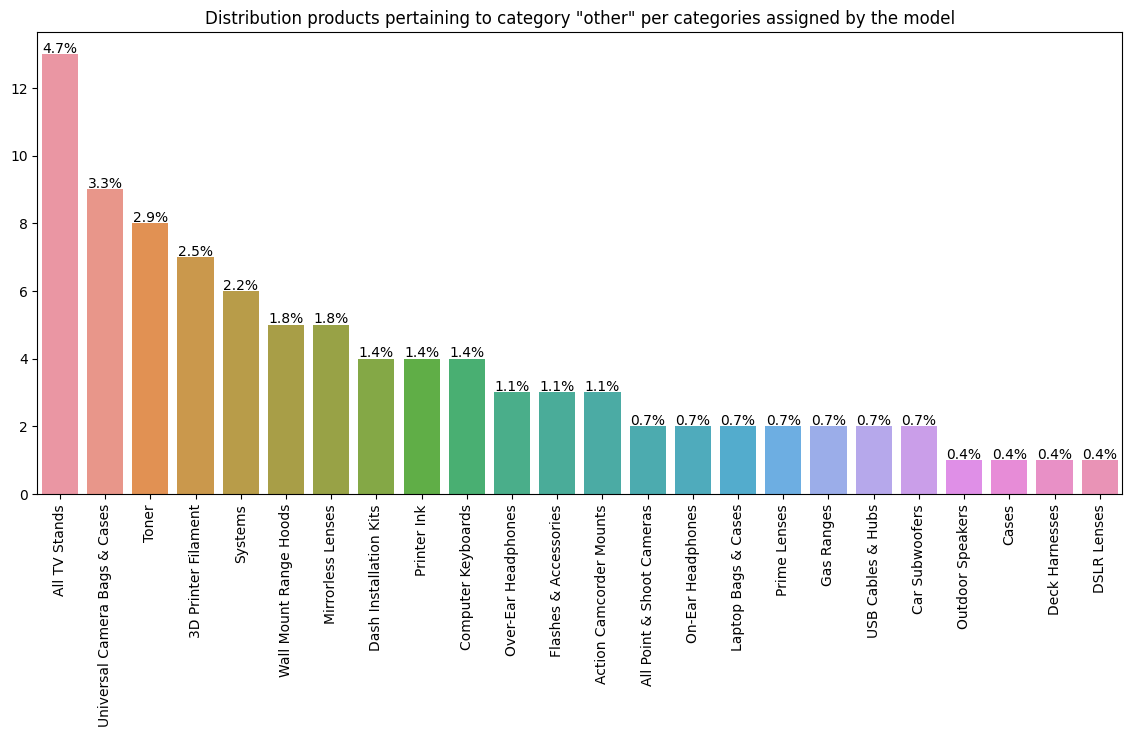

In [37]:
f = plt.figure(figsize=(14, 6))
x = pred_cat_no_other
y = count_pred_cat_no_other
percentage = perc_pred_cat_no_other
ax = sns.barplot(x=x, y=y)
patches = ax.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()+.05
   ax.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')
plt.xticks(rotation=90)

plt.title("""Distribution products pertaining to category "other" per categories assigned by the model""")
plt.show()

#### **Products misclassified excluding those pertaining to "other"**


In [38]:
# top-five categories worst predicted
probl_cat_5 = df_bad_pred_ens['true_cat_dec'].value_counts().index.to_list()[1:6]

In [39]:
df_model_ens_subset= df_model_ens[df_model_ens['true_cat_dec'].isin(probl_cat_5)]
df_model_ens_subset 

,pred_cat,true_cat,pred_cat_dec,true_cat_dec,dist
15,pcmcat284800050007,abcat0410022,Camera Batteries,Camcorder Accessories,3
107,other,pcmcat128500050004,other,Name Brands,1
259,pcmcat377500050003,pcmcat377500050003,Apple Watch Bands & Straps,Apple Watch Bands & Straps,0
264,pcmcat251300050004,pcmcat251300050004,Food Preparation Utensils,Food Preparation Utensils,0
272,abcat0912014,pcmcat179200050003,Electric Griddles & Hotplates,Grills,4
...,...,...,...,...,...
10073,other,pcmcat377500050003,other,Apple Watch Bands & Straps,4
10116,pcmcat251300050004,pcmcat251300050004,Food Preparation Utensils,Food Preparation Utensils,0
10217,pcmcat251300050004,pcmcat251300050004,Food Preparation Utensils,Food Preparation Utensils,0
10240,abcat0401000,pcmcat128500050004,Digital Cameras,Name Brands,2


In [40]:
y_pred_ens_subset = df_model_ens_subset['pred_cat_dec']
y_true_ens_subset = df_model_ens_subset['true_cat_dec']

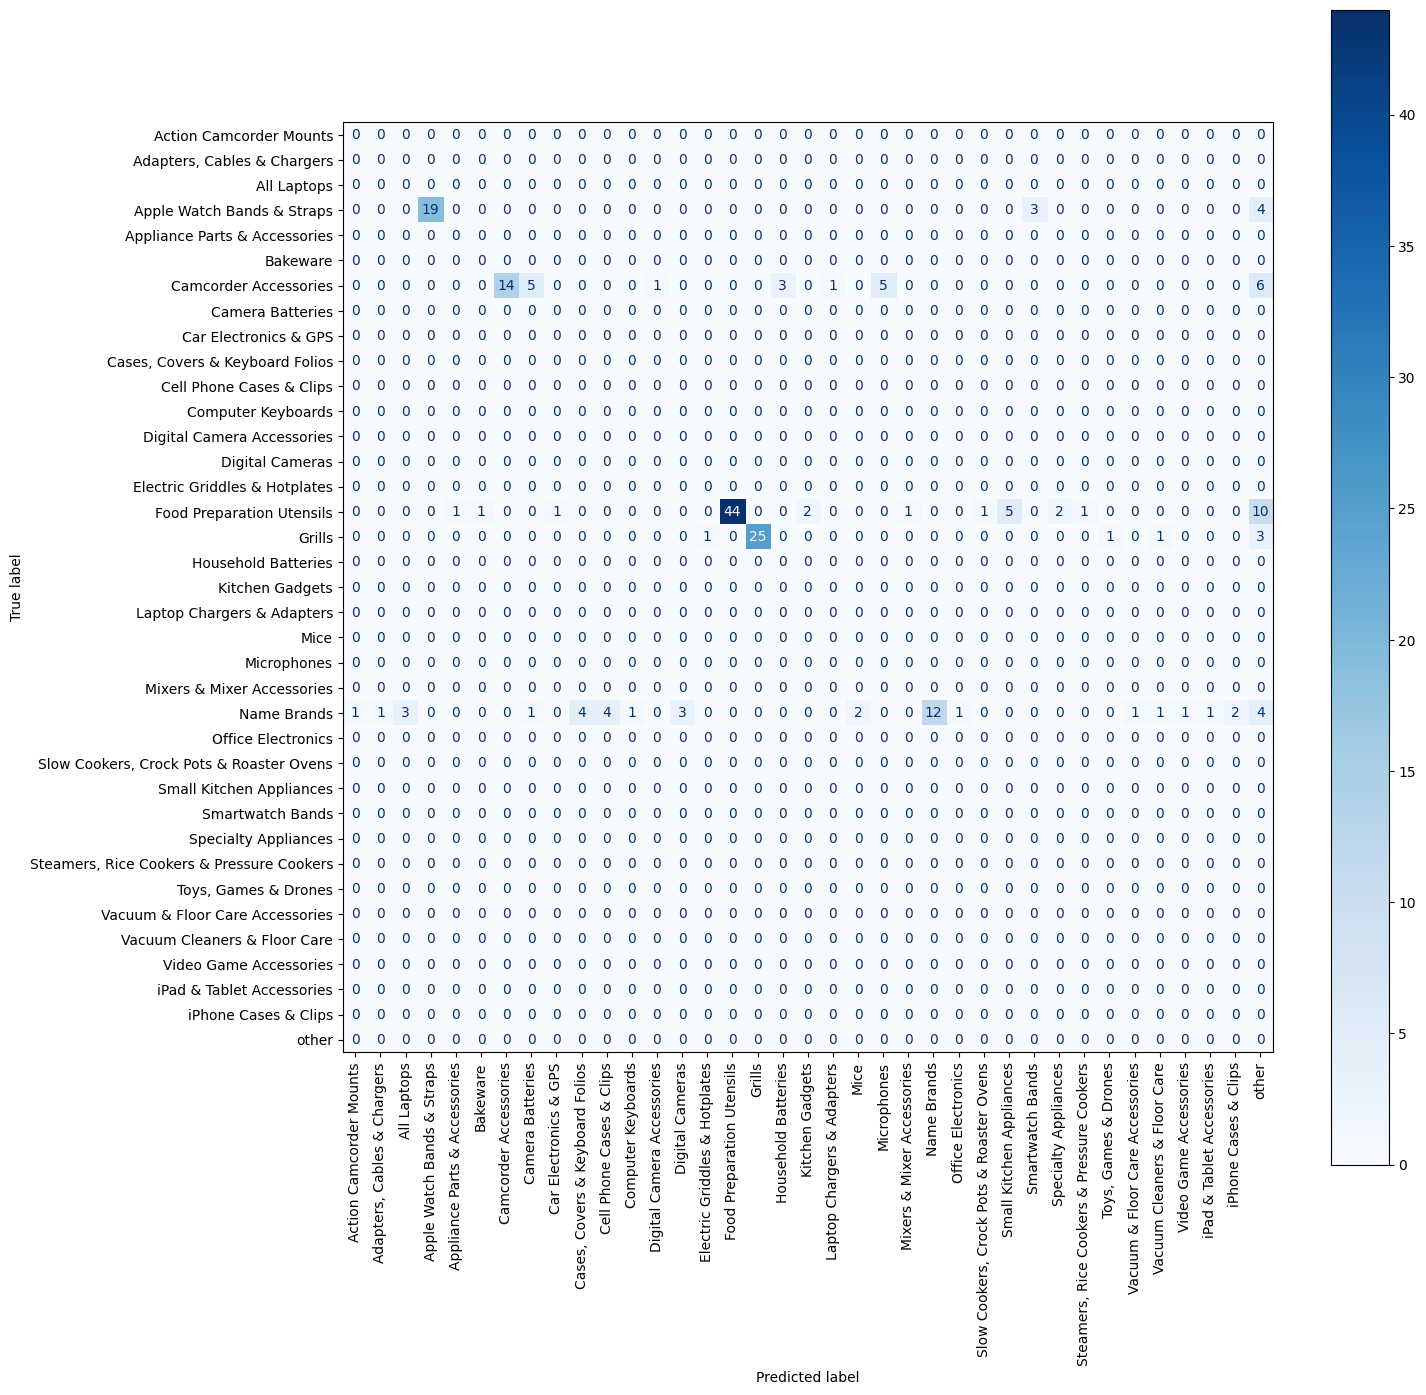

In [41]:
f,ax = plt.subplots(1,1,figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_true=y_true_ens_subset, 
                                        y_pred=y_pred_ens_subset, 
                                        xticks_rotation='vertical', 
                                        cmap= 'Blues',
                                        ax=ax)
plt.show()